In [2]:
import os
import time
import pickle
import roadrunner
import numpy as np
import pandas as pd
import pocomc as pc
import seaborn as sns
import matplotlib.pyplot as plt

RESULT_FNAME = "tester_result.pkl"
results = {}
with open(RESULT_FNAME, "rb") as f:
    results = pickle.load(f)
print(results.keys())

MODEL_FNAME = "tester_mod.pkl"
mod_opts = {}
with open(MODEL_FNAME, "rb") as f:
    mod_opts = pickle.load(f)
print(mod_opts.keys())

sbml_file = "mRNA_sbml.xml"
librr_model = roadrunner.RoadRunner(sbml_file)
mod_opts['librr_model'] = librr_model

dict_keys(['samples', 'loglikelihood', 'logprior', 'logz', 'iter', 'x', 'logl', 'logp', 'logw', 'ess', 'ncall', 'beta', 'accept', 'scale', 'steps'])
dict_keys(['theta_n', 'ODE_params_n', 'x_n', 'fit_x0', 'x0', 'observable_idxs', 'fit_sigma', 'theta_true', 'lower_bnds', 'upper_bnds', 'ts', 'data', 'librr_theta', 'librr_species'])


In [3]:
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values

    def __call__(self, theta_new):
        theta_new = theta_new
        res = self.log_likelihood(theta_new)
        return res
    
    def change_and_run(self, model_param, x0):
        rr = self.librr_model
        rr.resetAll()
        rr.integrator.absolute_tolerance = 5e-10
        rr.integrator.relative_tolerance = 1e-8

        for spec_name, val in zip(self.librr_species, x0):
            init_species_string = f"init([{spec_name}])"
            rr[init_species_string] = float(val)
            rr.reset()
        
        for name, value in zip(self.librr_theta, model_param):
            rr[name] = float(value)
            rr.reset() # forces initial conditions and BNGL functions to be re-evaluated
        
        t_span = (self.ts[0], self.ts[-1])
        trajs = rr.simulate(t_span[0], t_span[1], int(t_span[1]*100+1))
        return trajs    
        
    def call_sim(self, model_param = None, x0 = None, return_all_species=False): #takes in candidate parameters then solves the ode
        if model_param is None:
            model_param= self.theta_true[:self.ODE_params_n]  
        if x0 is None:
            x0 = self.x0 
        
        trajs = self.change_and_run(model_param, x0)
        if return_all_species:
            return trajs
        
        sim_ts = trajs[:, 0]
        species = trajs[:, 1:]
        # ! TO DO: Assumes simulation includes data ts which is not always the case
        # ! Need to add interpolation for times not included in simulation
        t_idxs = np.where(np.in1d(sim_ts, self.ts))[0]
        return_species = species[t_idxs, self.observable_idxs]
        return return_species
    
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: 
            return 0.0 
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this candidate parameter fitting my data (maximize it)
        model_param = theta_new[:self.ODE_params_n] 
        if self.fit_x0: 
            x0 = theta_new[self.ODE_params_n:(self.ODE_params_n + self.x_n)] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0

        if self.fit_sigma:
            sigma = theta_new[-len(self.observable_idxs):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observable_idxs) #makes all sigmas default to 1
        y = self.call_sim(model_param=model_param, x0=x0) #sets y to the y results of solving ODE
        data = self.data #sets data

        # Calculate likelihood
        term1 = -0.5 * np.log(2*np.pi*np.square(sigma))
        term2 = np.square(np.subtract(y, data)) / (2*np.square(sigma))
        logLH = np.sum(term1 - term2)
        return np.array(logLH)
    
mod = Model(mod_opts)

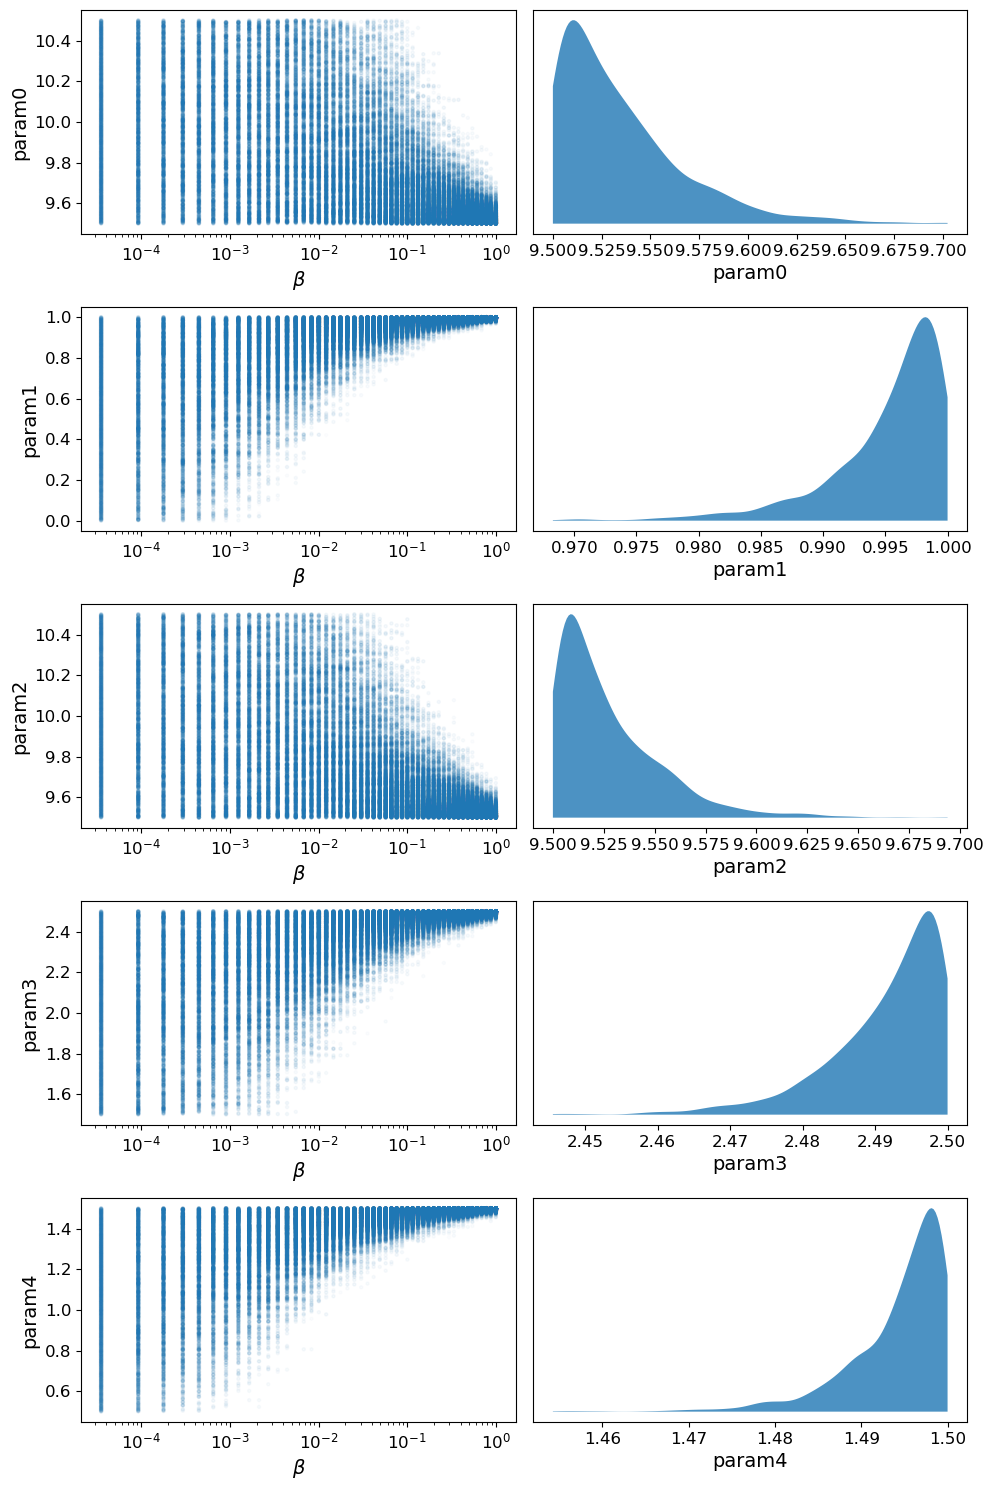

In [4]:
pc.plotting.trace(results, labels=mod.librr_theta);

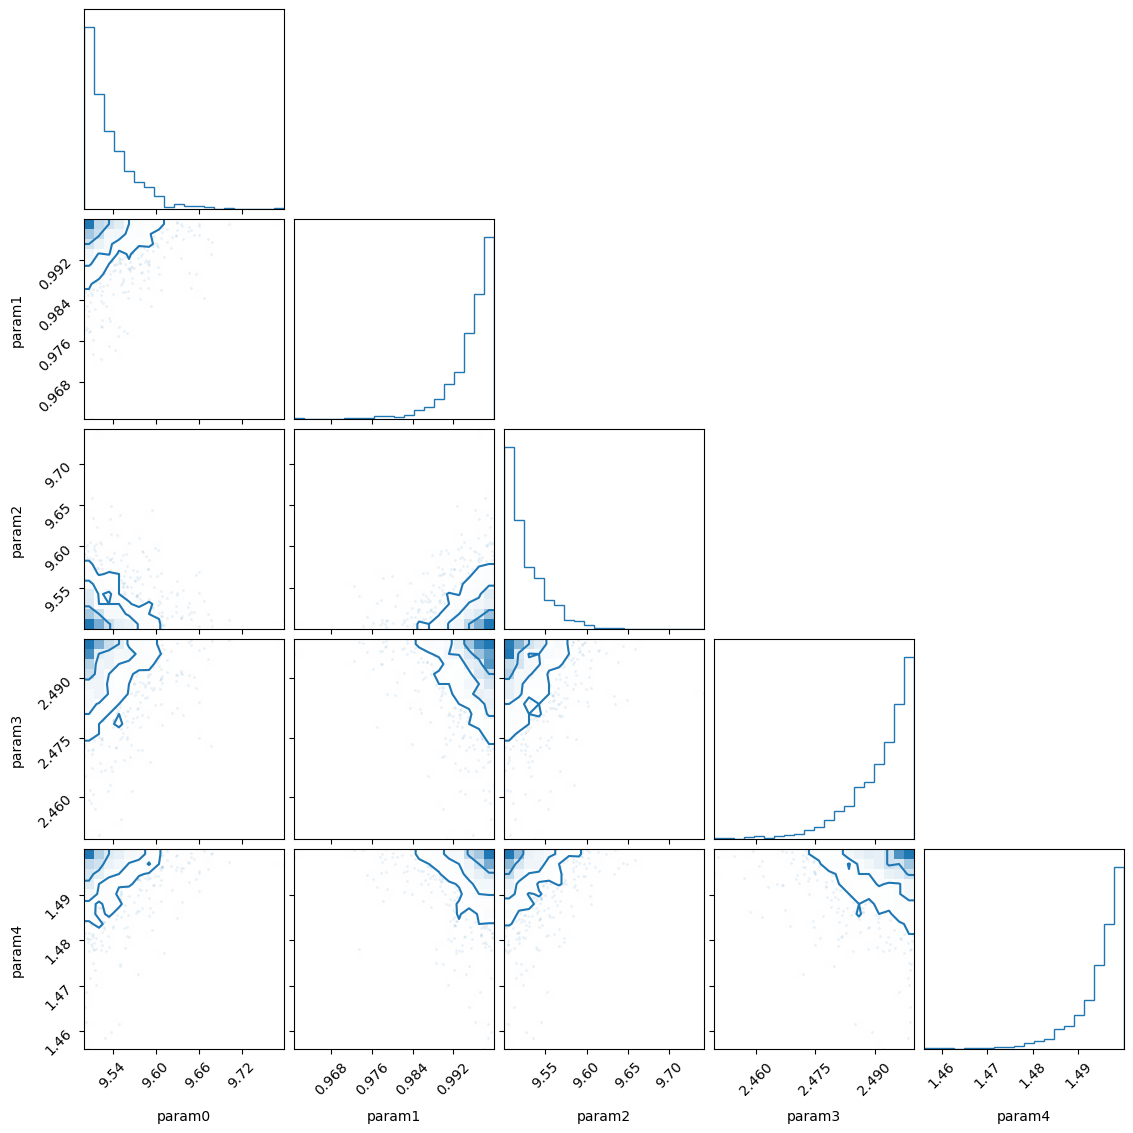

In [5]:
pc.plotting.corner(results, labels=mod.librr_theta);